# Plotting Audio Samples

Use this notebook to plot waveforms and spectrograms of the obtained audio samples from training and evaluation.

In [9]:
import torchaudio
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy import fft, signal

# Set global default values for pyplot
plt.rcParams['lines.linewidth'] = 1         # Set the default linewidth  
plt.rcParams['axes.grid'] = True           # Enable grid lines
plt.rcParams['font.size'] = 10              # Set the default linewidth

plt.rcParams['figure.dpi'] = 100                        # Set figure quality
plt.rcParams['figure.figsize'] = (8, 5)                # Set default figure size
# plt.rcParams['savefig.directory'] = plots_dir                 # Set figure quality when saving
plt.style.context('ggplot')                                     # Set the default style

# plt.rcParams.keys()                                           # List all the parameters

In [10]:
TRAIN_SAMPLES = Path("../audio/train")
EVAL_SAMPLES = Path("../audio/eval")
PLOTS_DIR = Path("../docs/plots/eval/")

start_idx = 0.0
end_idx = 0.25

In [11]:
def check_dc_offset(pred, target):
    pred_offset = pred.mean()
    target_offset = target.mean()
    dc_offset = pred_offset - target_offset

    # Smallest quantization step for 16-bit audio
    quantization_step_16bit = 1 / 32767.0

    # Check if the absolute value of the DC offset is smaller or larger than the quantization step
    if abs(dc_offset) < quantization_step_16bit:
        print("The DC offset is smaller than the smallest quantization step for 16-bit audio.")
    else:
        print("The DC offset is larger than the smallest quantization step for 16-bit audio.")

In [12]:
def plot_overlap_waveforms(output, target, sample_rate, start_idx, end_idx, title):    
    """Plots the output and target waveforms overlapped."""
    
    fs = sample_rate
    output = output[int(sample_rate * start_idx):int(sample_rate * end_idx)]
    target = target[int(sample_rate * start_idx):int(sample_rate * end_idx)]
 
    T = 1 / fs                              # sampling interval
    t = np.arange(start_idx,end_idx, T)     # Time vector

    plt.figure()
    plt.plot(t, output, alpha=0.8, label="Model")
    plt.plot(t, target, alpha=0.8, label="Target")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
def plot_overlap_time_freq(output, target, sample_rate, start_idx, end_idx, title):

    output = output[int(sample_rate * start_idx):int(sample_rate * end_idx)]
    target = target[int(sample_rate * start_idx):int(sample_rate * end_idx)]
    
    fs = sample_rate
    T = 1 / fs                              # sampling interval
    t = np.arange(start_idx,end_idx, T)     # Time vector
    N = len(output)                         # FFT size

    # Compute FFT with the window 
    w = signal.get_window('flattop', N)     # Window function
    output_fft = fft.rfft(output * w) / N   # FFT normalized by the FFT size 
    target_fft = fft.rfft(target * w) / N   # FFT normalized by the FFT size
    
    output_fft = 20*np.log10(np.abs(output_fft[:N//2]))
    target_fft = 20*np.log10(np.abs(target_fft[:N//2]))

    xf = fft.rfftfreq(N, T)[:N//2]          # Calculate the frequencies

    fig,axs = plt.subplots(2,1)
    fig.suptitle(title)
    plt.sca(axs[0])
    plt.plot(t,output, alpha=0.6, label='Output')
    plt.plot(t,target, alpha=0.6, label='Target')
    plt.xlim(t[0],t[-1])
    plt.ylabel('Amplitude')
    plt.xlabel('Time [s]')
    plt.legend()
    
    plt.sca(axs[1])
    plt.semilogx(xf[:N//2], output_fft[:N//2], alpha=0.6,label='Output')
    plt.semilogx(xf[:N//2], target_fft[:N//2], alpha=0.6,label='Target')
    plt.xlim(50,5000)
    plt.ylim(-110, -20)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    
    # Set x-axis ticks
    custom_ticks = [50, 100, 250, 500, 1000, 2000, 3000, 5000]
    plt.xticks(custom_ticks, custom_ticks)

    # plt.savefig(f'{PLOTS_DIR / title}.png')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
def process_directory(directory_path, start_idx, end_idx):
    """
    Walk through directory_path, and for each pair of pred_{some_model_name}.wav and targ_{same_model_name}.wav, 
    load them using torchaudio and call overlap_waveforms and two_spectrograms_difference functions.
    """
    directory_path = Path(directory_path)
    output_files = [f for f in directory_path.iterdir() if f.name.startswith("pred") and f.suffix == ".wav"]
    
    for out_file in output_files:
        # Construct the expected name for the target file by replacing "pred" with "targ"
        tgt_file_name = out_file.name.replace("pred", "target")
        tgt_file = directory_path / tgt_file_name
        
        if tgt_file.exists():
            # Load the audio files using torchaudio
            output, sample_rate = torchaudio.load(out_file)
            target, _ = torchaudio.load(tgt_file)
            
            output = output.view(-1).numpy()
            target = target.view(-1).numpy()

            title = out_file.stem  # Use the original stem of the prediction file as the title
            title = title[5:]
            # Call the plotting functions
            # plot_overlap_waveform(output, target, sample_rate, start_idx, end_idx, title)
            plot_overlap_time_freq(output, target, sample_rate, start_idx, end_idx, title)
        else:
            print(f"Matching target file for {out_file} not found!")

In [15]:
process_directory(TRAIN_SAMPLES, start_idx, end_idx)

Matching target file for ../audio/train/pred-lstm-32-bx-c2-20230914-181038-48k.wav not found!
Matching target file for ../audio/train/pred-lstm-32-kt-c2-20230914-141243-48k.wav not found!
Matching target file for ../audio/train/pred-lstm-32-bx-c2-20230914-164349-48k.wav not found!
Matching target file for ../audio/train/pred-gru-4-bx-c2-20230914-163307-48k.wav not found!
Matching target file for ../audio/train/pred-tcn-3200-kt-c2-20230914-135239-48k.wav not found!
Matching target file for ../audio/train/pred-gcn-2500-kt-c2-20230914-135309-48k.wav not found!
Matching target file for ../audio/train/pred-tcn-3200-bx-c2-20230914-174608-48k.wav not found!
Matching target file for ../audio/train/pred-gru-4-kt-c2-20230914-141946-48k.wav not found!
Matching target file for ../audio/train/pred-gcn-2500-bx-c2-20230914-161920-48k.wav not found!


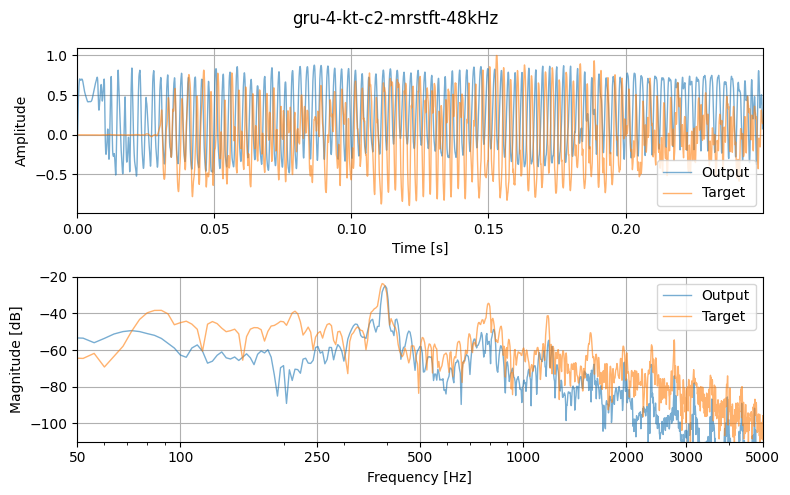

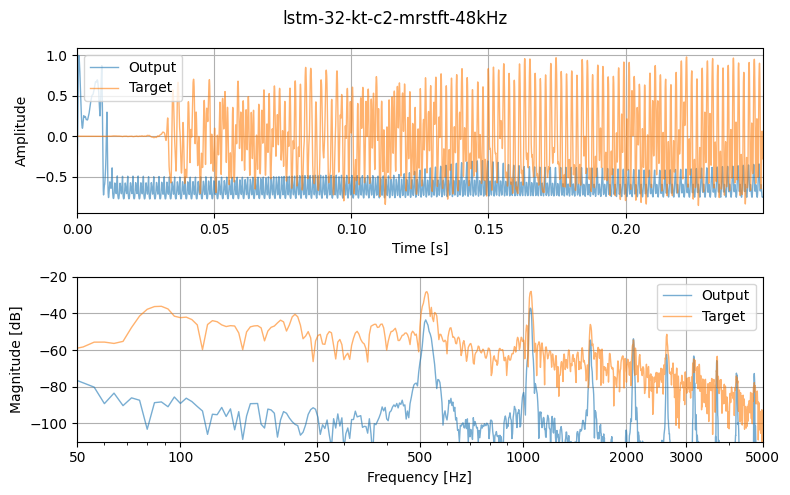

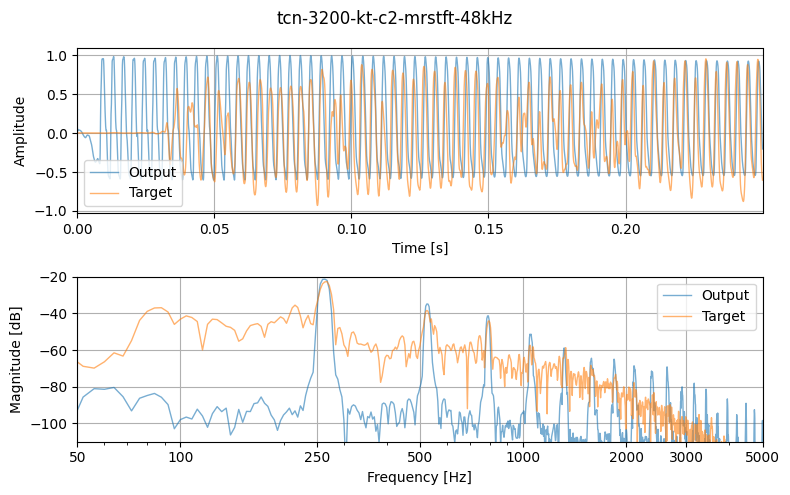

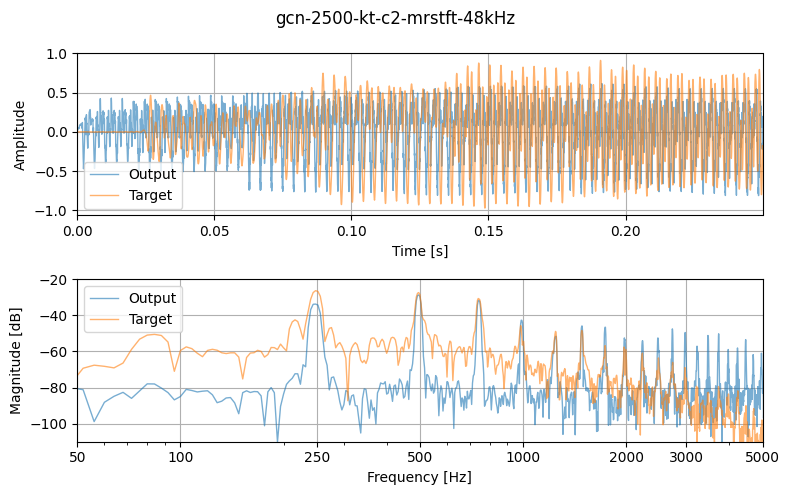

In [16]:
process_directory(EVAL_SAMPLES, start_idx, end_idx)